# Exploratory Data Analysis for Randomized Redistricting

This Jupyter notebook documents all steps that encompass the Exploratory Data Analysis (EDA) phase of the [random-redistricter](https://github.com/sherwinhlee/random-redistricter) project. Tasks include data pre-processing, wrangling, mining, and everything in-between. The input is the raw election returns file from MIT Election Data and Science Lab. The output will be a dataset that can be used for vote aggregation when the new districts are drawn.

Last updated: December 29, 2018

In [1]:
%reset
import matplotlib as plt
import numpy as np
import pandas as pd
import os

# Read input .csv into dataframe
parent = os.path.realpath('..')
in_file = '2016-precinct-house.csv'
df = pd.read_csv(parent + '\\data\\raw\\' + in_file, encoding='ISO-8859-1')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


C:\Users\Sherwin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Since we'll end up dropping the offending columns from the dataframe, we'll ignore the data type warning above. Next steps are to do very surface-level EDA tasks, like seeing how many missing values we have in the columns that are important and also verifying that the entire dataset is for the 2016 general election.

In [2]:
print('Years included: ',df['year'].unique())
print('Election stages included: ',df['stage'].unique())
df.isnull().sum()

Years included:  [2016]
Election stages included:  ['gen']


year                           0
stage                          0
special                        0
state                          0
state_postal                   0
state_fips                     0
state_icpsr                    0
county_name                 3858
county_fips                 3246
county_ansi                 3858
county_lat                  3858
county_long                 3858
jurisdiction                   0
precinct                       0
candidate                   4922
candidate_normalized        4922
office                         0
district                   34607
writein                        0
party                     213192
mode                           0
votes                          0
candidate_opensecrets     737640
candidate_wikidata        737640
candidate_party           737640
candidate_last            737640
candidate_first           737640
candidate_middle          947195
candidate_full            737640
candidate_suffix         1113939
candidate_

With that out of the way, let's start processing our dataset. We begin by copying the dataframe with only relevant columns retained. Then we convert values for the 'candidate' and 'party' columns to lowercase - this will make filtering and all that jazz much more manageable. pandas will also freak out about writing to a copy, not the original dataframe, so let's disable that warning as well.

In [3]:
# Create new dataframe with relevant columns
df2 = df[['state_postal','state_fips','county_fips',
          'jurisdiction','precinct','candidate','district',
          'writein','party','votes','candidate_party']]

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Convert candidate and party values to lowercase
df2['party'] = df2['party'].str.lower()
df2['candidate_party'] = df2['candidate_party'].str.lower()
df2['candidate'] = df2['candidate'].str.lower()

Since there are currently no Independents in Congress, a simplifying assumption is that we ignore third-party candidates. Ultimately, this project is concerned with the power balance in a two-party system. As you can see below, there are lots of third parties, all of which we will drop. Let's begin by filtering these out with a basic string filter. As you can see, there is only one false positive - the "representing the 99%" party - which we remove manually. A lot of candidates have also filed addendums to their party names, like "independent" or "constitution." For standardization, we want all remaining party values to be either "democratic" or "republican."

In [4]:
parties = df2['party'].unique()
print('All political parties:')
print(parties)

# String filter for only Democratic or Republican candidates
two_party = [p for p in parties if 'dem' in str(p) or 'rep' in str(p)]
print('\nParties we can simplify as Democratic or Republican:')
print(two_party)
two_party.remove('representing the 99%')

# Create dictionary to map to binary party values 
party_dict = {}
for val in two_party:
    if 'dem' in val:
        party_dict[val] = 'democratic'
    elif 'rep' in val:
        party_dict[val] = 'republican'
        
# Standardize D/R party values
df2['party'] = df2['party'].replace(party_dict)
df2['candidate_party'] = df2['candidate_party'].replace({'democrat': 'democratic'})

# Keep only records with D/R party values
df2 = df2[(df2['party'].isnull()) | (df2['party']=='democratic') | (df2['party']=='republican') | (df2['candidate_party']=='democratic') | (df2['candidate_party']=='republican')]        

All political parties:
[nan 'democratic' 'republican' "people's party" 'libertarian'
 'new alliance' 'green' 'independent' 'working families'
 'dc statehood green' 'none' 'nonpartisan' 'constitution'
 'nominated by petition' 'american delta' 'nopty' 'other' 'unaffiliated'
 'bot' 'unenrolled' 'us taxpayers' 'natural law party' 'wcp'
 'democratic-farmer-labor' 'legal marijuana now' 'independence' 'veterans'
 'reform' 'independent american' "people's independent progressive"
 'representing the 99%' 'for political revolution' 'make government work'
 'wake up america' 'nsa did 911' 'american independents'
 'we deserve better' 'financial independence' 'new beginnings'
 'women of power' 'conservative' "women's equality"
 'transparent government' "people's choice" 'upstate jobs'
 'stop the iran deal' 'harris bhatti' 'blue lives matter' 'democrat'
 'republican, independent' 'pacific green'
 'democrat, independent, working families' 'republican, constitution'
 'democrat, independent' 'progressiv

With the pre-processing above, we can now merge the following two columns to make our lives easier: **"party"** and **"candidate_party"**. Similarly, we will also drop write-in votes, which is predicated on the reasonable assumption that there has not been a major successful write-in campaign in a while. 

In [5]:
# Merge party and candidate_party columns
df2['party'] = df2['party'].where(df2['candidate_party'].isnull())
df2['party'] = df2.party.combine_first(df2.candidate_party)
df2.drop(['candidate_party'], axis=1)

# Drop write-ins
df2 = df2.drop(df2[df2['writein']].index)

As a corollary to the previous step, another major pre-processing stop is to ensure that all records we work with have a political party, specific Democrat or Republican. With this massive dataset, we will invariably have many records that lack a value for political party. There are two steps to get around this:
1. **Dropping records with no clear associated parties** - removing records that aren't even actual candidates, missed write-in candidates, additional Independents, and non-serious candidates who have very few votes. All these should fall outside the Democratic/Republican classification.
2. **Imputing political party** - checking to see if candidates have other records where a party is assigned and if not, then manually imputing them through quick search engine queries. 

Let's first begin by auditing the number of records that require such processing. We'll then list out all unique candidate names.

In [6]:
no_party = df2[df2['party'].isnull()]
print(len(no_party),'records do not have a political party.')
no_party['candidate'].unique()

88083 records do not have a political party.


array(['brianna barksdale', 'brian deshazo', 'j m grogan',
       'kent j mcgrew', 'for', 'for all the unopposed candidates.',
       'for unopposed', 'vote for', 'for all unopposed',
       'for unopposed candidates', 'vote for all',
       'roman gabriel gonzalez', 'preston picus', 'curtis imrie',
       'robert nelson franz iii', 'rachelle lee linney', 'campbell smith',
       'scott walker', 'nathan russo', 'leonard ware',
       'james neal harris', 'greg duke', 'patricia c. mccracken',
       'patrick a. boggs', 'don wilson', 'angela pendley', 'douglas bell',
       'rodney stooksbury', 'rashid malik', 'victor armendariz',
       'mark d. wicklund', 'rob sherman', 'patrick harlan', 'james bales',
       'britani potter', 'samuel l. gaskins', 'nancy jo kemper',
       'calvin sidle', 'straight party', 'harold bratcher',
       'dresser, jay parker', 'holbrook', 'all others',
       'overton, richard miller', 'arnold, joshua', 'bentivolio, kerry',
       'lynch, clyde darnell', 'sc

As it appears, there are a lot of election "candidates" that aren't really candidates at all. Stuff like "scatter" and "affidavit" inevitably show up throughout the massive data compilation process. The step below creates an array of all values that are clearly non-person entities. All records matching these values are then dropped - we will assume these are inconsequential to the overall analysis.

In [7]:
# Set of non-person candidate names for removal
nh = np.array(['for', 'for all the unopposed candidates.',
       'for unopposed', 'vote for', 'for all unopposed',
       'for unopposed candidates', 'vote for all',
       'straight party', 'all others', 'scatter', 
       'personal choice','scattering', 'affidavit',
       'manually counted emergency', 'federal', 
       'absentee/military', 'special presidential', 
       'special votes'], dtype=object)

# Drop records with non-person candidate values
no_party = no_party.drop(no_party[no_party['candidate'].isin(nh)].index)
df2 = df2.drop(df2[df2['candidate'].isin(nh)].index)

The array below lists the resulting set of unique candidate names who don't have an associated party. Names are rendered lower-case to get around case-sensitivity issues. As we can see, some names are evidently not actual candidates, like Ben Affleck, who I wasn't aware ran for Congress. These were most likely write-ins but did not get flagged as such. We'll then group all the records by candidate, summing up the total votes. To give us a bit more visual intuition, let's also plot the number of votes that these remaining candidates got.

In [8]:
no_party['candidate'].unique()

array(['brianna barksdale', 'brian deshazo', 'j m grogan',
       'kent j mcgrew', 'roman gabriel gonzalez', 'preston picus',
       'curtis imrie', 'robert nelson franz iii', 'rachelle lee linney',
       'campbell smith', 'scott walker', 'nathan russo', 'leonard ware',
       'james neal harris', 'greg duke', 'patricia c. mccracken',
       'patrick a. boggs', 'don wilson', 'angela pendley', 'douglas bell',
       'rodney stooksbury', 'rashid malik', 'victor armendariz',
       'mark d. wicklund', 'rob sherman', 'patrick harlan', 'james bales',
       'britani potter', 'samuel l. gaskins', 'nancy jo kemper',
       'calvin sidle', 'harold bratcher', 'dresser, jay parker',
       'holbrook', 'overton, richard miller', 'arnold, joshua',
       'bentivolio, kerry', 'lynch, clyde darnell', 'david h. cole',
       'steven fenichel', 'james keenan', 'john ordille',
       'eric beechwood', 'gabriel brian franco',
       'lawrence w. berlinski,jr', 'frederick john lavergne',
       'michael

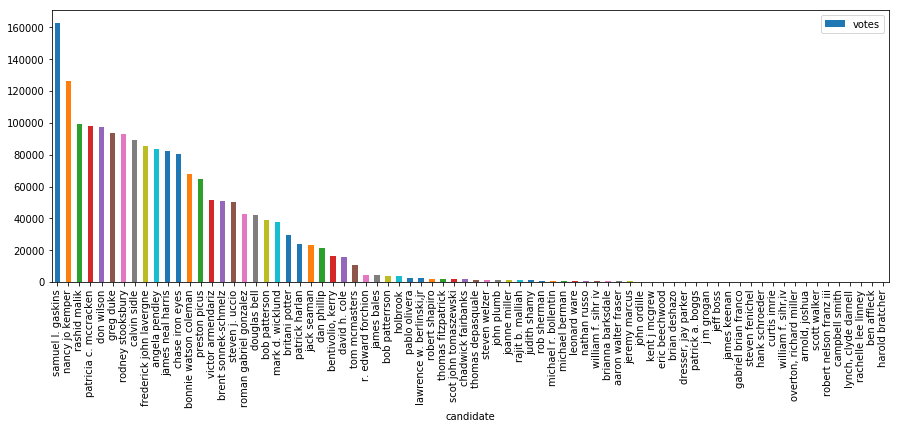

In [9]:
# Replace NaN values with dummy to handle groupby operation for missing values
no_party['district'] = no_party['district'].fillna(999)

# Group "no party" candidates and sum up votes
rem = no_party.groupby(['candidate','state_postal','district']).sum().sort_values(['votes'],
                       ascending=False)
rem = rem.reset_index()[['candidate','state_postal','district','votes']]

# Plot functions
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]
rem.plot(x='candidate',y='votes',kind="bar")

In [10]:
# Candidates in the main dataframe grouped by name and district, with votes summed
cand = df2.groupby(['state_postal','district','candidate']).sum().sort_values(['district'])
cand = cand.reset_index()

# Loop through lookup table and print candidates + results for those districts
for idx, row in rem.iterrows():
    print(row[0], '('+row[1]+'-'+str(row[2])+'),', 'votes:', row[3])
    if row[2] == 999:
        df2 = df2.drop(df2[(df2['candidate']==row[0]) & (df2['state_postal']==row[1])].index)
        print('ACTION: Drop candidate.','\n')
    else:
        x = df2.loc[df2['candidate']==row[0],['party']]['party'].unique()
        if len(x)==1:
            total = cand[(cand['state_postal']==row[1]) & (cand['district']==row[2])]['votes'].sum()
            match = df2[(df2['state_postal']==row[1]) & (df2['district']==row[2])]
            pv = pd.pivot_table(match, values='votes', index=['candidate'], columns='party', aggfunc=np.sum)
            print(pv)
            print('Proportion of district votes:',round(row[3]/total,2))
            print('ACTION: Process manually.','\n')
        else:
            if str(x[0]) == 'nan':
                df2.loc[(df2['candidate']==row[0]) & (df2['state_postal']==row[1]),['party']] = x[1]
                print('ACTION: Impute party:',x[1],'\n')
            else:
                df2.loc[(df2['candidate']==row[0]) & (df2['state_postal']==row[1]),['party']] = x[0]
                print('ACTION: Impute party:',x[0],'\n')

samuel l. gaskins (KY-1.0), votes: 162523
party                republican
candidate                      
harold (hal) rogers        1625
james r. comer           426764
Proportion of district votes: 0.28
ACTION: Process manually. 

nancy jo kemper (KY-6.0), votes: 126323
ACTION: Impute party: democratic 

rashid malik (GA-7.0), votes: 99389
ACTION: Impute party: democratic 

patricia c. mccracken (GA-12.0), votes: 98115
ACTION: Impute party: democratic 

don wilson (GA-11.0), votes: 97283
ACTION: Impute party: democratic 

greg duke (GA-2.0), votes: 93429
ACTION: Impute party: republican 

rodney stooksbury (GA-6.0), votes: 93001
ACTION: Impute party: democratic 

calvin sidle (KY-4.0), votes: 89555
ACTION: Impute party: democratic 

frederick john lavergne (NJ-3.0), votes: 85242
ACTION: Impute party: democratic 

angela pendley (GA-3.0), votes: 83865
ACTION: Impute party: democratic 

james neal harris (GA-8.0), votes: 82587
ACTION: Impute party: democratic 

chase iron eyes (ND-0.0)

party               democratic  republican
candidate                                 
bob patterson              NaN    107078.0
donald w. norcross    181350.0         NaN
Proportion of district votes: 0.0
ACTION: Process manually. 

leonard ware (GA-10.0), votes: 886
party      republican
candidate            
jody hice      243725
Proportion of district votes: 0.0
ACTION: Process manually. 

nathan russo (GA-1.0), votes: 869
party                    republican
candidate                          
earl âbuddyâ carter      210243
Proportion of district votes: 0.0
ACTION: Process manually. 

william f. sihr iv (NJ-1.0), votes: 674
party               democratic  republican
candidate                                 
bob patterson              NaN    107078.0
donald w. norcross    181350.0         NaN
Proportion of district votes: 0.0
ACTION: Process manually. 

brianna barksdale (AZ-999.0), votes: 529
ACTION: Drop candidate. 

aaron walter fraser (NJ-10.0), votes: 490
party           

Now for the most exciting part! We'll iterate through the remaining 46 candidates and "sort" them into one of three arrays: Democratic, Republican, or third-party. Since these edge cases are tough to handle in one generalized algorithm, this exercise is best performed manually and involves a lot of Googling. Luckily, 46 isn't too bad. We then impute the correct party for candidates in the former two sets and delete records of the latter.

In [11]:
imp_dem = np.array([('samuel l. gaskins','KY'), ('chase iron eyes','ND'),
                   ('britani potter','KS')], dtype=object)
imp_rep = np.array([('bob patterrson','NJ')], dtype=object)
delete = np.array([('preston picus','CA'), ('roman gabriel gonzalez','CA'),
                  ('jack seaman','ND'), ('dan phillip','OH'), ('bentivolio, kerry','MI'),
                  ('tom mcmasters','OH'), ('r. edward forchion','NJ'),
                  ('james bales','KS'), ('pablo olivera','NJ'),
                  ('lawrence w. berlinski,jr','NJ'), ('robert shapiro','NJ'),
                  ('thomas fitzpatrick','NJ'), ('scot john tomaszewski','NJ'),
                  ('chadwick fairbanks','UT'), ('thomas depasquale','NJ'),
                  ('steven welzer','NJ'), ('joanne miller','NJ'),
                  ('rajit b. malliah','NJ'), ('judith shamy','NJ'),
                  ('rob sherman','IL'), ('michael r. bollentin','NJ'),
                  ('michael berman','NJ'), ('leonard ware','GA'),
                  ('nathan russo','GA'), ('william f. sihr iv','NJ'),
                  ('aaron walter fraser','NJ'), ('jeremy marcus','NJ'),
                  ('john ordille','NJ'), ('eric beechwood','NJ'),
                  ('dresser, jay parker','ME'), ('patrick a. boggs','GA'),
                  ('jeff boss','NJ'), ('james keenan','NJ'),
                  ('gabriel brian franco','NJ'), ('steven fenichel','NJ'),
                  ('hank schroeder','NJ'), ('curtis imrie','CO'),
                  ('william f. sihr,iv','NJ'), ('overton, richard miller','MI'),
                  ('arnold, joshua','MI'), ('lynch, clyde darnell','MI'),
                  ('ben affleck','NY')], dtype=object)

# Impute parties if democratic or republican, delete if neither
for d in imp_dem:
    df2.loc[(df2['candidate']==d[0]) & (df2['state_postal']==d[1]),['party']] = 'democratic'
for r in imp_rep:
    df2.loc[(df2['candidate']==r[0]) & (df2['state_postal']==r[1]),['party']] = 'republican'
for i in delete:
    df2 = df2.drop(df2[(df2['candidate']==i[0]) & (df2['state_postal']==i[1])].index)

And we're done! Let's export the processed dataframe to a new .csv file, which we can then use to aggregate votes once new districts are redrawn.

In [12]:
out_file = 'processed_returns.csv'
df2.to_csv(parent + '\\data\\processed\\' + out_file)